# 05. Distribution Shift Quantification

## Goal
- Formally quantify the "shift" between 2014-2016 (Train) and 2018-2019 (Test).
- Metrics:
    1.  **Population Stability Index (PSI)**: Industry standard for credit risk.
    2.  **Wasserstein Distance**: Measures the "work" needed to transform one distribution to another.
- Visualization: Kernel Density Estimates (KDE) for drifting features.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
import os

%matplotlib inline

In [35]:
# --- DRIVE SETUP ---
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/credit_risk_project'
    DATA_DIR = os.path.join(PROJECT_DIR, 'data/processed')
    RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
    FIGURES_DIR = os.path.join(RESULTS_DIR, 'figures')
    os.makedirs(FIGURES_DIR, exist_ok=True)
except ImportError:
    PROJECT_DIR = '..'
    DATA_DIR = '../data/processed'
    FIGURES_DIR = '../results/figures'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Load Data
try:
    df_train = pd.read_pickle(os.path.join(DATA_DIR, 'train_final.pkl'))
    df_ood = pd.read_pickle(os.path.join(DATA_DIR, 'ood_final.pkl'))
    
    # Verify we only have numeric features (drop target for drift analysis)
    target_col = 'target'
    X_train = df_train.drop(target_col, axis=1, errors='ignore').select_dtypes(include=np.number)
    X_ood = df_ood.drop(target_col, axis=1, errors='ignore').select_dtypes(include=np.number)
    
    print(f"Train Features: {X_train.shape}")
    print(f"OOD Features: {X_ood.shape}")
except FileNotFoundError:
    print("Data not found. Please run previous notebooks.")

Train Features: (891754, 37)
OOD Features: (56318, 37)


In [37]:
# Define PSI Function
def calculate_psi(expected, actual, buckets=10):
    '''Calculate the PSI (Population Stability Index) for a single feature
       expected: training data feature
       actual: ood data feature
    '''
    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

    if len(np.unique(expected)) < 5:
        # Categorical/Discrete case
        breakpoints = np.unique(expected)
        
    else:
        # Continuous case
        breakpoints = np.percentile(expected, breakpoints)

    # Calculate frequency in each bucket
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)

    # Avoid division by zero
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)

    psi_value = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
    return psi_value

In [38]:
# Calculate Drift Metric for All Features
drift_results = []

for col in X_train.columns:
    # Drop NA just in case
    a = X_train[col].dropna().values
    b = X_ood[col].dropna().values
    
    # PSI
    try:
        psi = calculate_psi(a, b, buckets=10)
    except:
        psi = np.nan
        
    # Wasserstein
    wd = wasserstein_distance(a, b)
    
    drift_results.append({'Feature': col, 'PSI': psi, 'Wasserstein': wd})

df_drift = pd.DataFrame(drift_results)
df_drift = df_drift.sort_values(by='PSI', ascending=False)

print("Top 10 Drifted Features (by PSI):")
print(df_drift.head(10))

Top 10 Drifted Features (by PSI):
            Feature       PSI  Wasserstein
13       revol_util  0.299577     0.548199
8    fico_range_low  0.177361     0.477537
9   fico_range_high  0.177361     0.477532
12        revol_bal  0.087283     0.097928
2          int_rate  0.077940     0.174146
0         loan_amnt  0.051080     0.139273
6               dti  0.044858     0.250909
3       installment  0.042638     0.116307
4             grade  0.033639     0.118588
14        total_acc  0.025950     0.120098


In [39]:
# Save Drift Table
df_drift.to_csv(os.path.join(RESULTS_DIR, 'tables/feature_drift.csv'), index=False)
print("Drift table saved.")

Drift table saved.


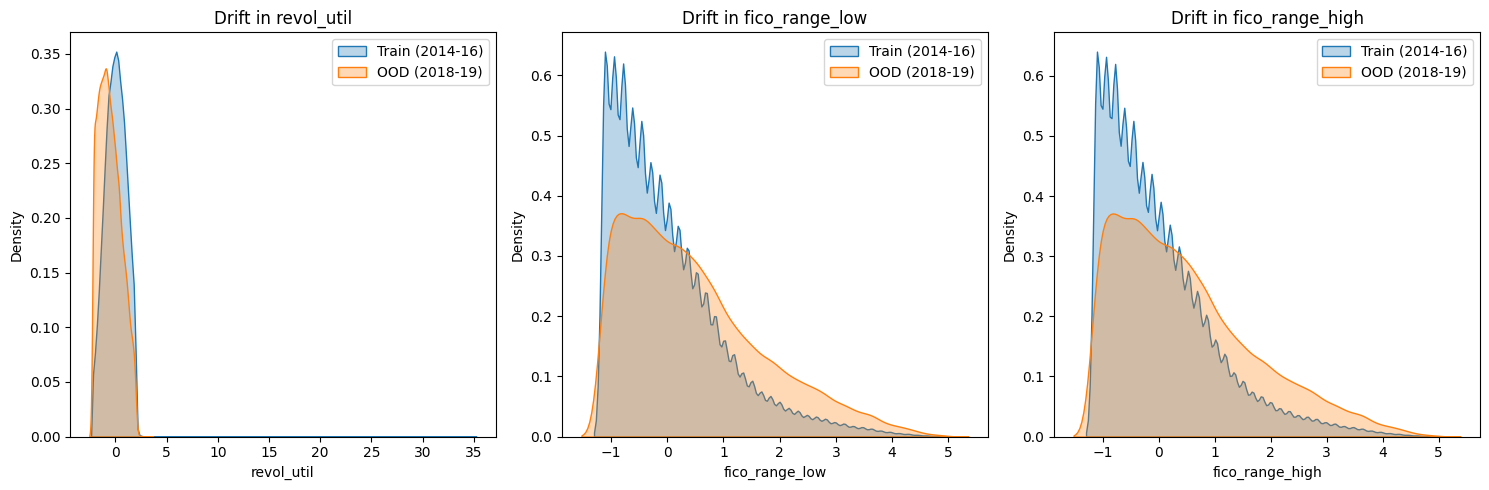

In [40]:
# Visualize Top 3 Drifted Features
top_features = df_drift.head(3)['Feature'].values

plt.figure(figsize=(15, 5))
for i, feat in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(X_train[feat], label='Train (2014-16)', fill=True, alpha=0.3)
    sns.kdeplot(X_ood[feat], label='OOD (2018-19)', fill=True, alpha=0.3)
    plt.title(f'Drift in {feat}')
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'feature_drift_kde.png'))
plt.show()